In [54]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tqdm import tqdm

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")


%reload_ext autoreload
%autoreload 2

In [55]:
dataset = pd.read_pickle('data/processed_dataset.pkl')
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Amazon,Microsoft,Google,NASDAQ,...,sfft0,sfft30,sfft60,sfft90,sfft120,sfft150,sfft180,sfft210,sfft240,sfft270
2017-08-28,40.035000,40.500000,39.982498,40.367500,38.136890,103864000,47.300999,67.923393,45.690498,6283.020020,...,0.219800,8.238168,15.609853,31.590706,42.742159,48.834737,67.821029,112.273177,183.011846,278.748665
2017-08-29,40.025002,40.779999,40.000000,40.727501,38.476994,118067600,47.702999,68.128555,46.064499,6301.890137,...,21.140412,2.576878,11.417417,26.343704,36.783003,48.608117,68.572540,113.161062,184.677567,277.808767
2017-08-30,40.950001,40.972500,40.652500,40.837502,38.580917,109078400,48.379501,69.023895,46.478500,6368.310059,...,9.563929,3.116668,7.195704,26.637345,36.801853,42.231074,61.420278,104.931351,175.081543,280.489625
2017-08-31,40.910000,41.130001,40.869999,41.000000,38.734444,107140400,49.029999,69.732681,46.966499,6428.660156,...,1.409922,8.729535,2.967766,21.735243,30.529453,42.368215,60.935163,104.878935,176.728770,273.037192
2017-09-01,41.200001,41.235001,40.907501,41.012501,38.746254,66364400,48.912498,68.958595,46.867001,6435.330078,...,0.442288,14.340604,1.236330,16.673304,30.744926,35.151254,61.292780,105.876802,178.017551,273.249255


In [56]:
n_feature = dataset.shape[1]
dataset['y'] = dataset['Close']


x = dataset.iloc[:, :n_feature].values
y = dataset.iloc[:, n_feature].values

split = int(dataset.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (1077, 44) trainY: (1077,)
testX: (270, 44) testY: (270,)


In [57]:
from model.VAE import VAE

In [58]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([n_feature, 400, 400, 400, 10])
model = model.to(device)
learning_rate = 0.00003
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=44, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=10, bias=True)
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=10, out_features=10, bias=True)
  (fc_var): Linear(in_features=10, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=400, bias=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=44, bias=True)
    (7): Sigmoid()
  )
)

[1/300] Loss: 224.11894416809082
[2/300] Loss: 212.94454097747803
[3/300] Loss: 202.51348686218262
[4/300] Loss: 192.85619354248047
[5/300] Loss: 184.53051280975342
[6/300] Loss: 177.7108278274536
[7/300] Loss: 172.42586421966553
[8/300] Loss: 168.31603527069092
[9/300] Loss: 164.98821353912354
[10/300] Loss: 159.9046869277954
[11/300] Loss: 152.1151943206787
[12/300] Loss: 143.072416305542
[13/300] Loss: 134.9792194366455
[14/300] Loss: 129.65603590011597
[15/300] Loss: 127.24650716781616
[16/300] Loss: 126.77635669708252
[17/300] Loss: 127.10524654388428
[18/300] Loss: 127.34934520721436
[19/300] Loss: 126.87089586257935
[20/300] Loss: 125.50203371047974
[21/300] Loss: 123.2886266708374
[22/300] Loss: 120.43854999542236
[23/300] Loss: 117.14827013015747
[24/300] Loss: 113.70780611038208
[25/300] Loss: 110.49312973022461
[26/300] Loss: 107.72144842147827
[27/300] Loss: 105.49653339385986
[28/300] Loss: 103.7952880859375
[29/300] Loss: 102.49585103988647
[30/300] Loss: 101.324632644653

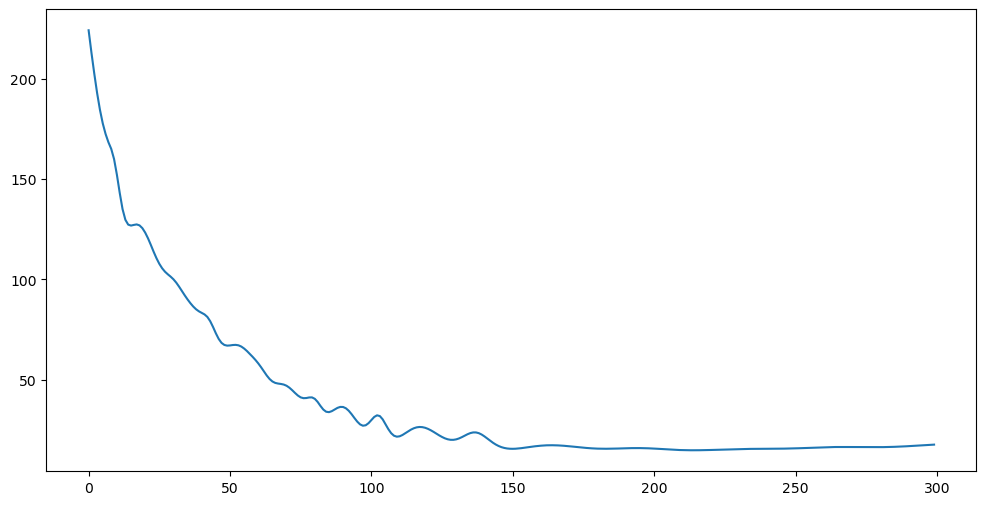

In [59]:
num_epochs = 300
hist = np.zeros(num_epochs) 

loss_func = nn.BCELoss()

for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = loss_func(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [60]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [61]:
def sliding_window(x, y, window, n_gen=1):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0] - n_gen):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + n_gen]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [62]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [63]:
num_days_for_predict = 3
num_days_to_predict = 1

In [64]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, num_days_for_predict, num_days_to_predict)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, num_days_for_predict, num_days_to_predict)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1073, 3, 54]) train_y: torch.Size([1073, 1]) train_y_gan: torch.Size([1073, 4, 1])
test_x: torch.Size([266, 3, 54]) test_y: torch.Size([266, 1]) test_y_gan: torch.Size([266, 4, 1])


In [70]:
from model.generator import Generator
from model.discriminator import Discriminator
from model.VAE import VAE

In [74]:
batch_size = 128
learning_rate = 0.00016
num_epochs = 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(
    input_size=model.config[0]+model.config[-1],
    output_size=num_days_to_predict
).to(device)
modelD = Discriminator(
    input_size=num_days_for_predict+num_days_to_predict,
).to(device)

criterion = nn.BCELoss()


In [99]:
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate)

In [108]:
num_epochs = 1000

In [110]:
histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0

modelG.train()
for epoch in tqdm(range(num_epochs)):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :num_days_for_predict, :], fake_data.reshape(-1, num_days_to_predict, 1)], axis = 1)
        # print(fake_data.shape)

        dis_real_output = modelD(y)
        # print(dis_real_output.shape)
        # break
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    # print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


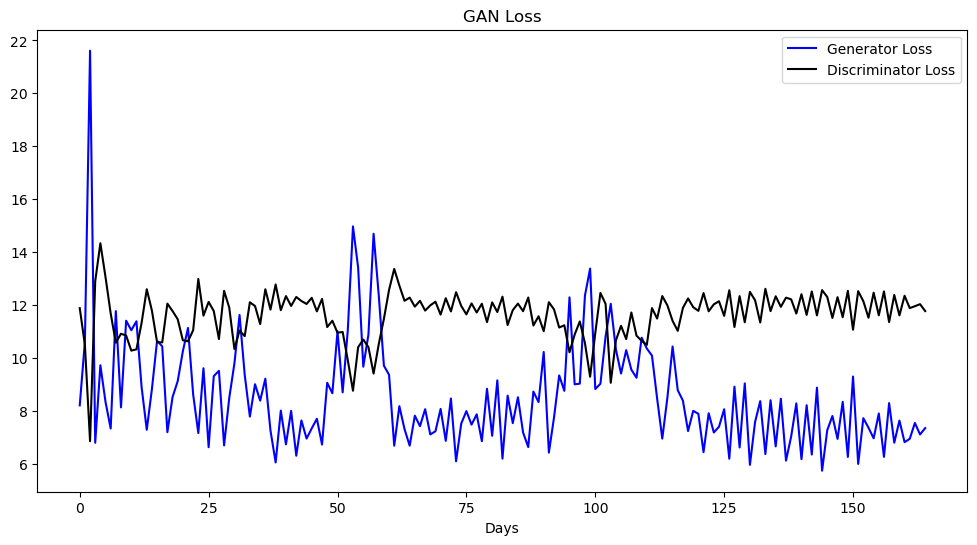

In [102]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [117]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

torch.Size([3, 3, 54])


Training dataset RMSE:2.4961677721293


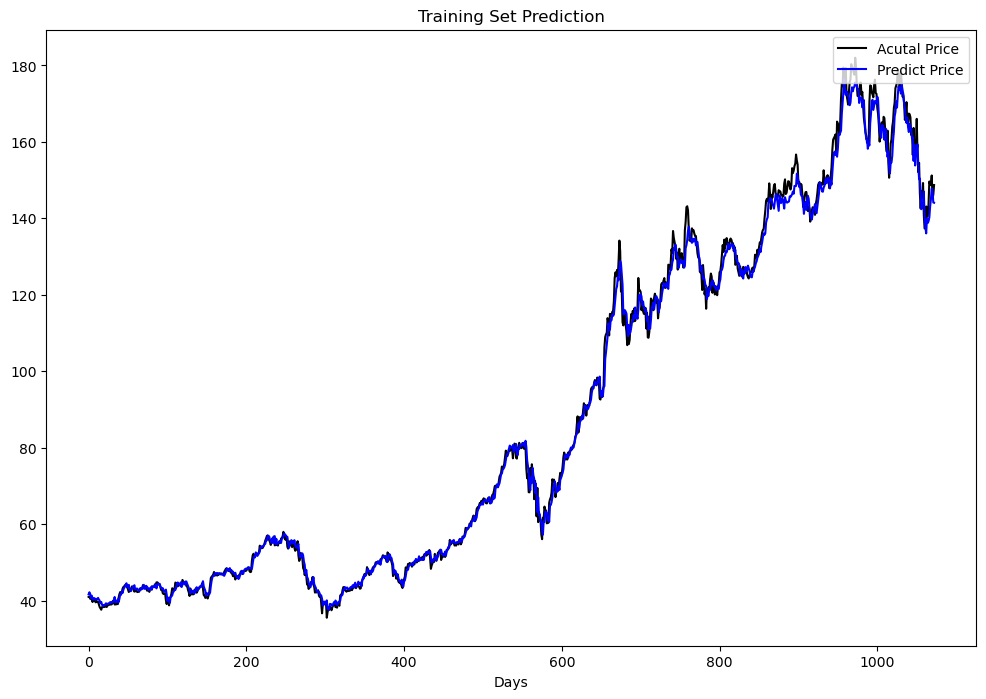

In [112]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('Training Set Prediction')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:11.876354060694235


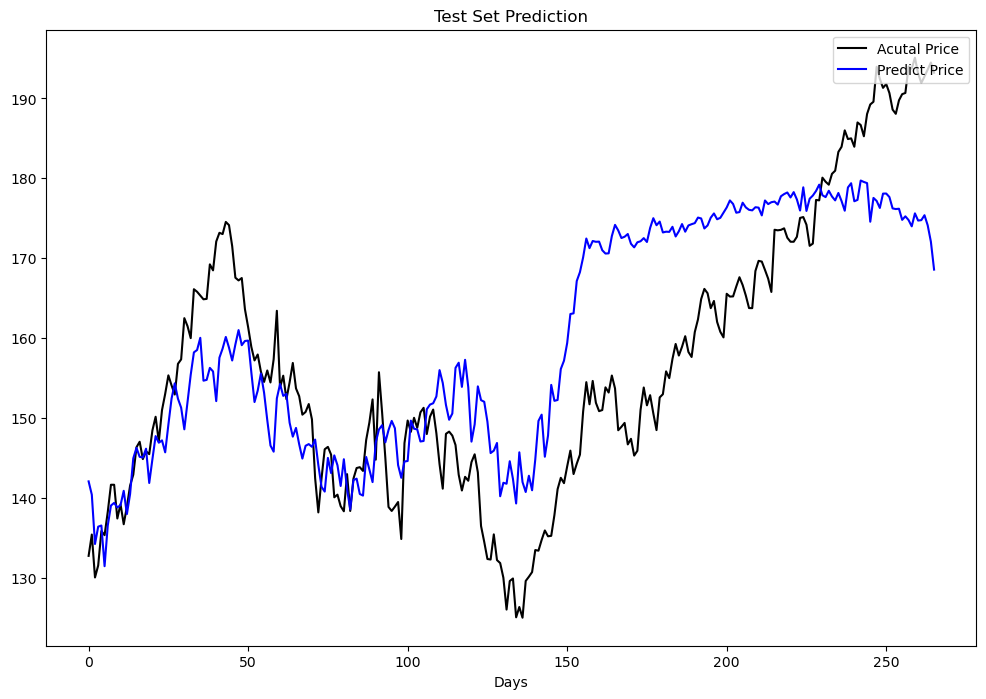

In [113]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('Test Set Prediction')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')